This notebook provides code used to create the eyetracking attention maps and drawing heatmaps for one image.
Note that some parts of the code might look unnecessary for a single example as they were taken from code used on all of our data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from utils import save_model, load_model, get_image


from skimage.morphology import dilation,square,disk
from math import dist

import csv
import pandas as pd
import re


def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

def get_percentage_of_image(image,mask,percentage):
    masked_image = np.zeros_like(image)
    n = mask.size
    sortedvalues = np.sort(mask.flatten('K'))[::-1]
    index = int(n/100*percentage)
    cutoff = sortedvalues[index]
    for i in range(3):
        masked_image[:,:,i] = np.where(mask-cutoff>0.0,image[:,:,i],0)
    return masked_image

def get_shapes(drawing_df):
    n = len(drawing_df.columns)//2
    shapes = []
    for i in range(n):
        shape = [x for x in zip(drawings[drawings.columns[i*2]],drawings[drawings.columns[i*2+1]]) if x[0] >= 0]
        shapes.append(shape)
    return shapes


def create_gaussian_bell(res,radius,scale=1.21e-3,mu=0):
    xx, yy =  np.meshgrid(np.arange(-radius, radius+1), np.arange(-radius, radius+1))

    bell = np.exp(-((xx - mu)*(xx - mu)+(yy - mu)*(yy - mu))*scale)
    
    for i in range(bell.shape[0]):
        for j in range(bell.shape[1]):
            if (np.sqrt((i-58)**2+(j-58)**2)>58):
                bell[i][j]=0
    return bell


def add_gaussian_bell_to_image(img, x, y, weight, res, radius, bell):
    """
    place precomputed bell to specific place on the image
    """
    
    assert 0 <= x < res
    assert 0 <= y < res
    
    # account for margin
    x += radius
    y += radius
    
    idx_x1 = x - radius
    idx_x2 = x + radius + 1
    
    idx_y1 = y - radius
    idx_y2 = y + radius + 1
    
    img[idx_x1:idx_x2, idx_y1: idx_y2] += bell*weight


def duration_distance_weighted_density_mask_gaussian(pixels,durations,size = (1024,1024),radius = 58):
    res = size[0]
    mask = np.zeros((res + 2*radius, res + 2*radius))
    bell = create_gaussian_bell(1024,58)
    for pixel,duration in zip(pixels,durations):
        add_gaussian_bell_to_image(mask,pixel[0],pixel[1],duration,res,radius,bell)
    mask = mask[radius:-radius,radius:-radius]
    return mask, ((mask-mask.min())/(mask.max()-mask.min()))



In [2]:
data_path = 'data/fixpoint_data_sample.csv'
image_path = 'data/images/'
data = pd.read_csv(data_path)


experimentlist = ['2_gazepointing']
imagelist = data.Picture_name.unique()
vp_list = data.Vpn.unique()

exp_dict = {}
for experiment in experimentlist:
    exp_dict[experiment] = {}
    exp_data = data.loc[data['Task'] == experiment]
    for image in imagelist:
        exp_dict[experiment][image] = {}
        image_data = exp_data.loc[exp_data['Picture_name'] == image]
        for vp in vp_list:
            exp_dict[experiment][image][vp] = []
            vp_data =  image_data.loc[image_data['Vpn'] == vp]
            for i, row in vp_data.iterrows():
                exp_dict[experiment][image][vp].append(((row['FixY_img'],row['FixX_img']),row['FixDur']))

In [3]:
print(exp_dict)

{'2_gazepointing': {'lighthouse53.jpg': {'Vp01': [((407.2, 741.2), 123), ((334.0, 733.3), 111), ((224.3, 749.9), 376), ((210.9, 750.7), 92)], 'Vp02': [((248.2, 751.2), 164), ((177.2, 757.1), 574), ((191.2, 766.4), 126)], 'Vp03': [((370.6, 725.5), 187), ((311.8, 771.2), 169), ((201.2, 766.5), 324)], 'Vp04': [((313.5, 734.2), 102), ((182.2, 764.1), 494)], 'Vp05': [((355.3, 757.6), 151), ((226.2, 766.4), 141), ((190.7, 768.2), 798)], 'Vp06': [((419.3, 688.4), 217), ((394.7, 753.8), 298)], 'Vp07': [((408.3, 707.2), 305), ((327.4, 743.1), 218), ((216.7, 741.9), 268), ((200.7, 754.2), 343), ((217.3, 742.8), 909), ((217.5, 743.5), 523), ((214.6, 739.0), 351)], 'Vp08': [((337.0, 698.3), 147), ((236.3, 726.7), 142), ((216.9, 737.5), 680)], 'Vp09': [((385.4, 712.3), 164), ((242.2, 732.9), 511), ((486.0, 655.4), 82), ((315.8, 755.0), 311), ((252.8, 755.8), 324)], 'Vp10': [((324.5, 750.5), 110), ((224.8, 737.0), 181), ((191.3, 758.4), 228)], 'Vp11': [((478.9, 476.9), 190), ((283.9, 715.1), 234), (

In [4]:
# Very short fixations are skipped since it is a reasonable assumption that no active processing of the area was happening.
min_fixation_duration = 180

image_data_dict = {}
for exp in exp_dict.keys():
    images_with_data = []
    for imagename in exp_dict[exp].keys():
        fixpoint_list = []
        fixpoint_durs_abs = []
        fixpoint_durs_rel = []
        for vp in exp_dict[exp][imagename].keys():
            fixpoint_list_vp = []
            fixpoint_durs_vp = []
            for entry in exp_dict[exp][imagename][vp]:
                if (entry[1]<min_fixation_duration):
                    continue
                fixpoint_list_vp.append(np.round(entry[0]))
                fixpoint_durs_vp.append(entry[1])
            fixpoint_durs_relative = fixpoint_durs_vp/np.sum(fixpoint_durs_vp)
            fixpoint_list.extend(np.array(fixpoint_list_vp,dtype = int))
            fixpoint_durs_abs.extend(fixpoint_durs_vp)
            fixpoint_durs_rel.extend(fixpoint_durs_relative)
        images_with_data.append((imagename,fixpoint_list,fixpoint_durs_abs,fixpoint_durs_rel))
    image_data_dict[exp] = images_with_data


In [5]:
#print(image_data_dict[list(image_data_dict.keys())[1]])

output_percentages = {}

In [6]:
import os
from PIL import Image, ImageDraw
for exp in image_data_dict.keys():
    images_with_data = image_data_dict[exp]
    output_percentages[exp] = []
    for imagedata in images_with_data:
        image_name,fixpoint_list,fixpoint_durs_abs,fixpoint_durs_rel = imagedata
        image = np.array(get_image(image_path + image_name))
        #Put method and parameters here, important choice: use absolute or relative durations for weighting?
        mask,mask_n = duration_distance_weighted_density_mask_gaussian(fixpoint_list,fixpoint_durs_abs)
        maskedimg = get_percentage_of_image(image,mask_n,5)
        shown_pc = np.mean(np.where(maskedimg != 0,1,0))
        output_percentages[exp].extend((image_name,shown_pc))
        



In [7]:
import cv2

def mask_on_image(mask,img,alpha=0.5):
    heatmap = get_rgb_heatmap(mask)
    img = img.squeeze()
    cam_on_img = (1-alpha)*img + alpha*heatmap
    return np.copy(cam_on_img)

def get_rgb_heatmap(mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    return np.copy(heatmap)


def normalize_image(img):
    return (img-img.min())/(img.max()-img.min())


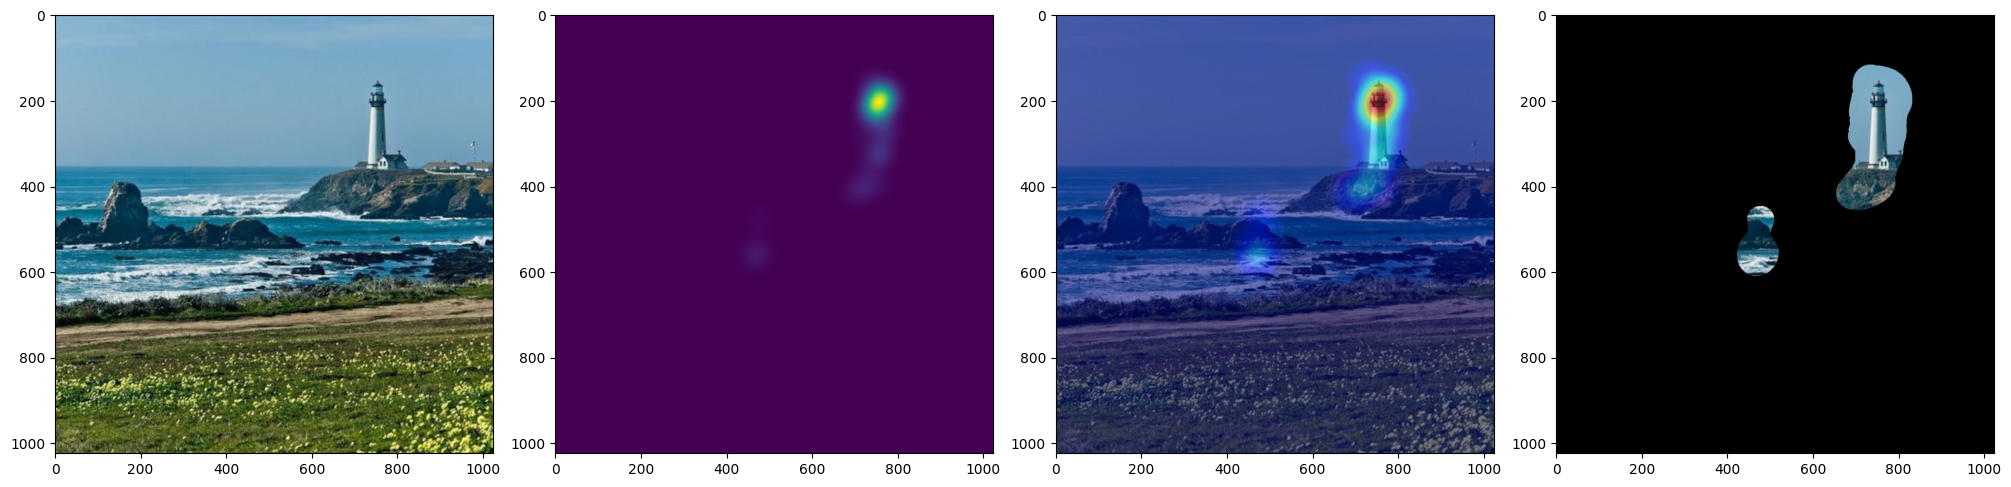

In [8]:
fig, axes = plt.subplots(1,4,constrained_layout = True,figsize=(20,8))
axes[0].imshow(image)
axes[1].imshow(mask)
axes[2].imshow(mask_on_image(normalize_image(np.sqrt(mask)),normalize_image(image),alpha=0.5))
axes[3].imshow(maskedimg)

We can look at the Mask and the results. As we can see there is a very strong focus on a single point making the other areas fade in comparison. For visualisation purposes the Square root of the heatmap was taken for the 3rd image, while the 4th image which was mostly used in our work represents a cutout of a 5% area consisting of the most important pixels according to the heatmap.

Let's look at the Heatmaps used for the relevant areas of the image drawn by the participants.
We derive the heatmap by simply overlaying all drawn polygones with equal weight.

In [9]:
drawings_path = 'data/drawings/'

orig_images = []
masked_images = []
image_masks = []

for imagename in imagelist:
    print(imagename)
    image = np.array(get_image(image_path + imagename))/255
    orig_images.append(image)
    drawings = pd.read_csv(drawings_path+imagename.split('.')[0] + '_coordinates.csv',delimiter=';')
    shapes = get_shapes(drawings)
    mask = np.zeros((image.shape[0],image.shape[1]))
    for i in range(len(shapes)):
        if len(shapes[i])==0:
            continue
        mask_shape = Image.new('L' , (image.shape[0],image.shape[1]),0)
        ImageDraw.Draw(mask_shape).polygon(shapes[i],outline=1,fill=1)
        mask = mask+mask_shape
    mask = mask/mask.max()
    image_masks.append(mask)
    masked_image = np.moveaxis(([np.multiply(image[:,:,i], mask) for i in range(3)]),0,2)
    masked_images.append(masked_image)


lighthouse53.jpg


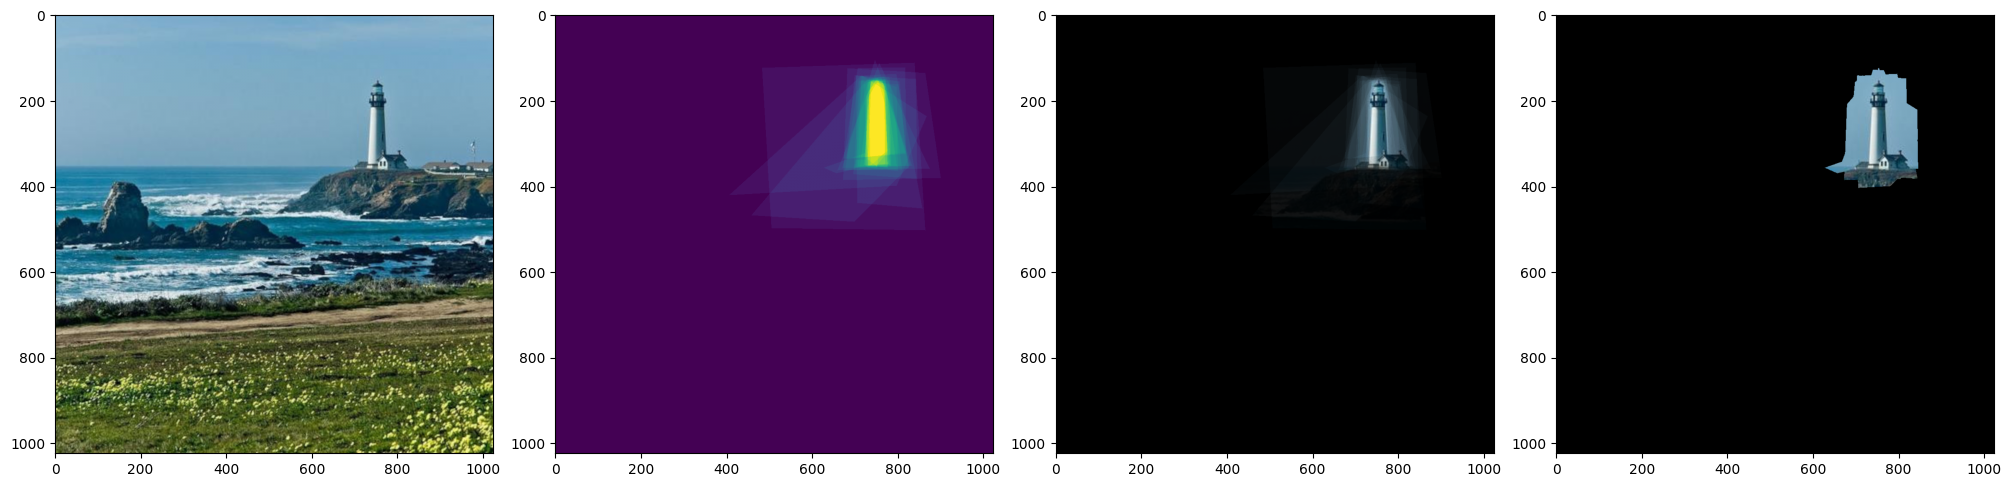

In [10]:
fig, axes = plt.subplots(1,4,constrained_layout = True,figsize=(20,8))
axes[0].imshow(orig_images[0])
axes[1].imshow(image_masks[0])
axes[2].imshow(masked_images[0])
image_cutout = get_percentage_of_image(orig_images[0],image_masks[0],5)
axes[3].imshow(image_cutout)


As we can see the drawings have hard edges, making it hard to decide which pixel is more important for a given area since they have the same value. This makes it impossible to decide which pixels should be included. In our case the cutout is actually ~25% smaller because of this, since adding all pixels scoring the next best in our heatmap would have pushed the size above 5% instead.

In [11]:
print("Size of cutout: " + str(np.mean(np.where(np.sum(image_cutout,axis=2)!=0,1,0))))

Size of cutout: 0.038275718688964844


We don't want to compare a 3.8% cutout from the drawing to the 5% cutout we get from the eyetracking heatmap.

To allow us to get images of the same size pixels are averaged over their direct neighbours. This can be considered as using average pooling. This is done 3 times. The number was decided on from imperical data, because it allowed to extract cutoffs extremely close to 5% of the image for all of our data.

In [12]:
def get_grad_mask(mask_orig,epochs=3,windowsize=1):

    mask_grad = np.copy(mask_orig)
    mask_grad_next = np.copy(mask_orig)

    for epoch in range(3):
        for i in range(mask_orig.shape[0]):
            for j in range(mask_orig.shape[1]):
                    startwindow_x = max(i-windowsize,0)
                    endwindow_x = min(i+windowsize,mask_orig.shape[0]-1)
                    startwindow_y = max(j-windowsize,0)
                    endwindow_y = min(j+windowsize,mask_orig.shape[1]-1)
                    mask_grad_next[i][j] = np.mean(mask_grad[startwindow_x:endwindow_x,startwindow_y:endwindow_y])
                    mask_grad = mask_grad_next
    return mask_grad

In [13]:
grad_mask = get_grad_mask(image_masks[0])

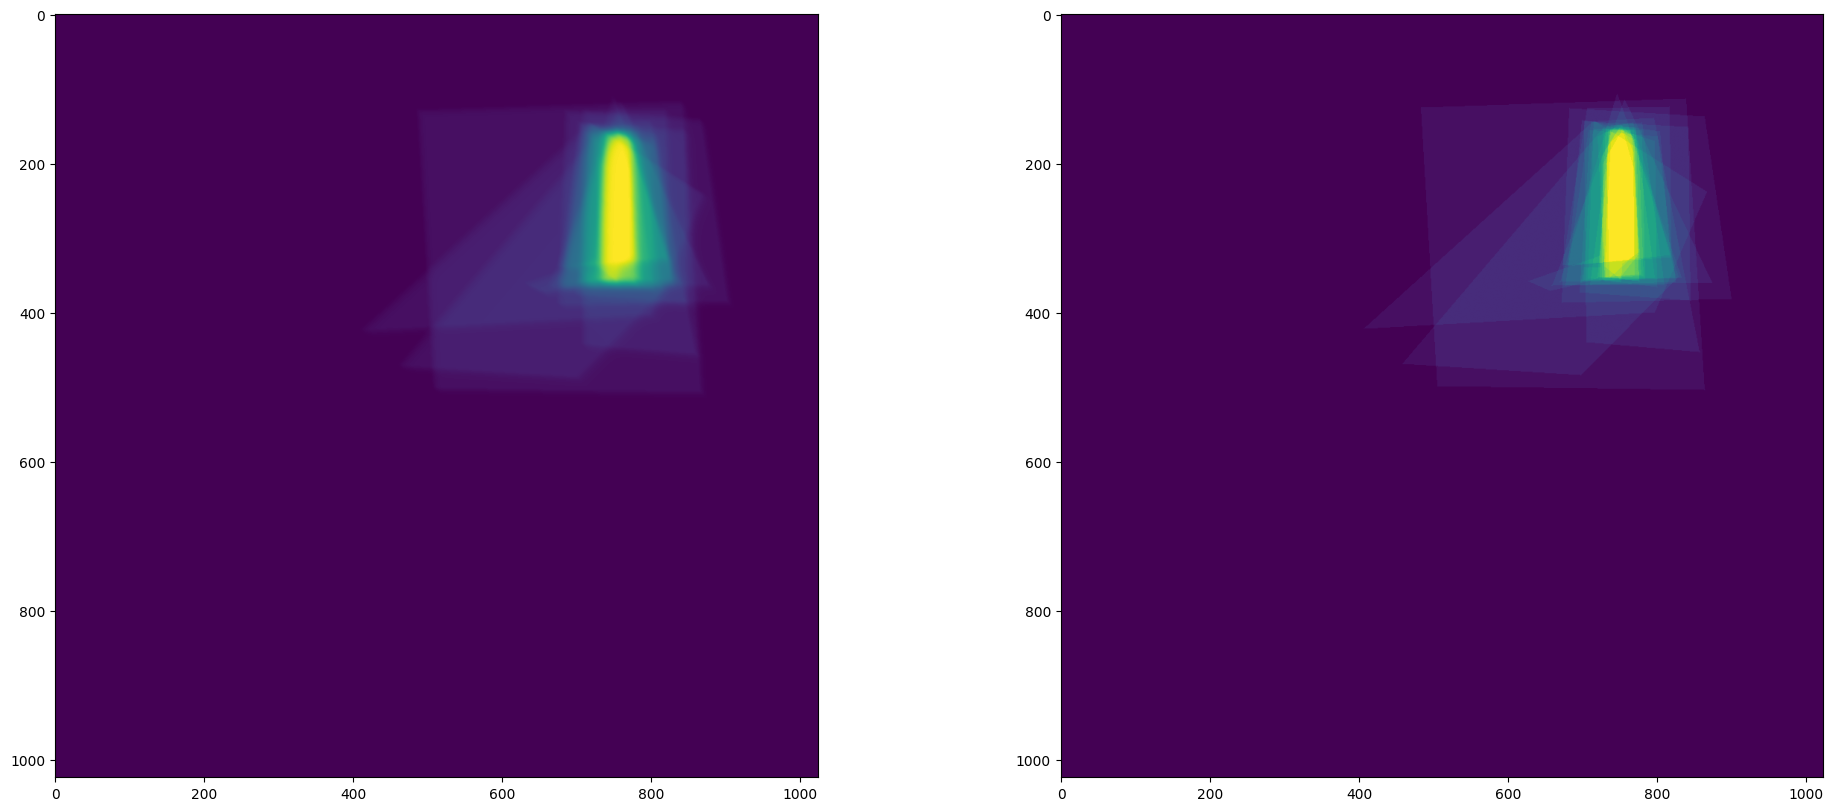

In [14]:
fig, axes = plt.subplots(1,2,constrained_layout = True,figsize=(20,8))
axes[0].imshow(grad_mask)
axes[1].imshow(image_masks[0])

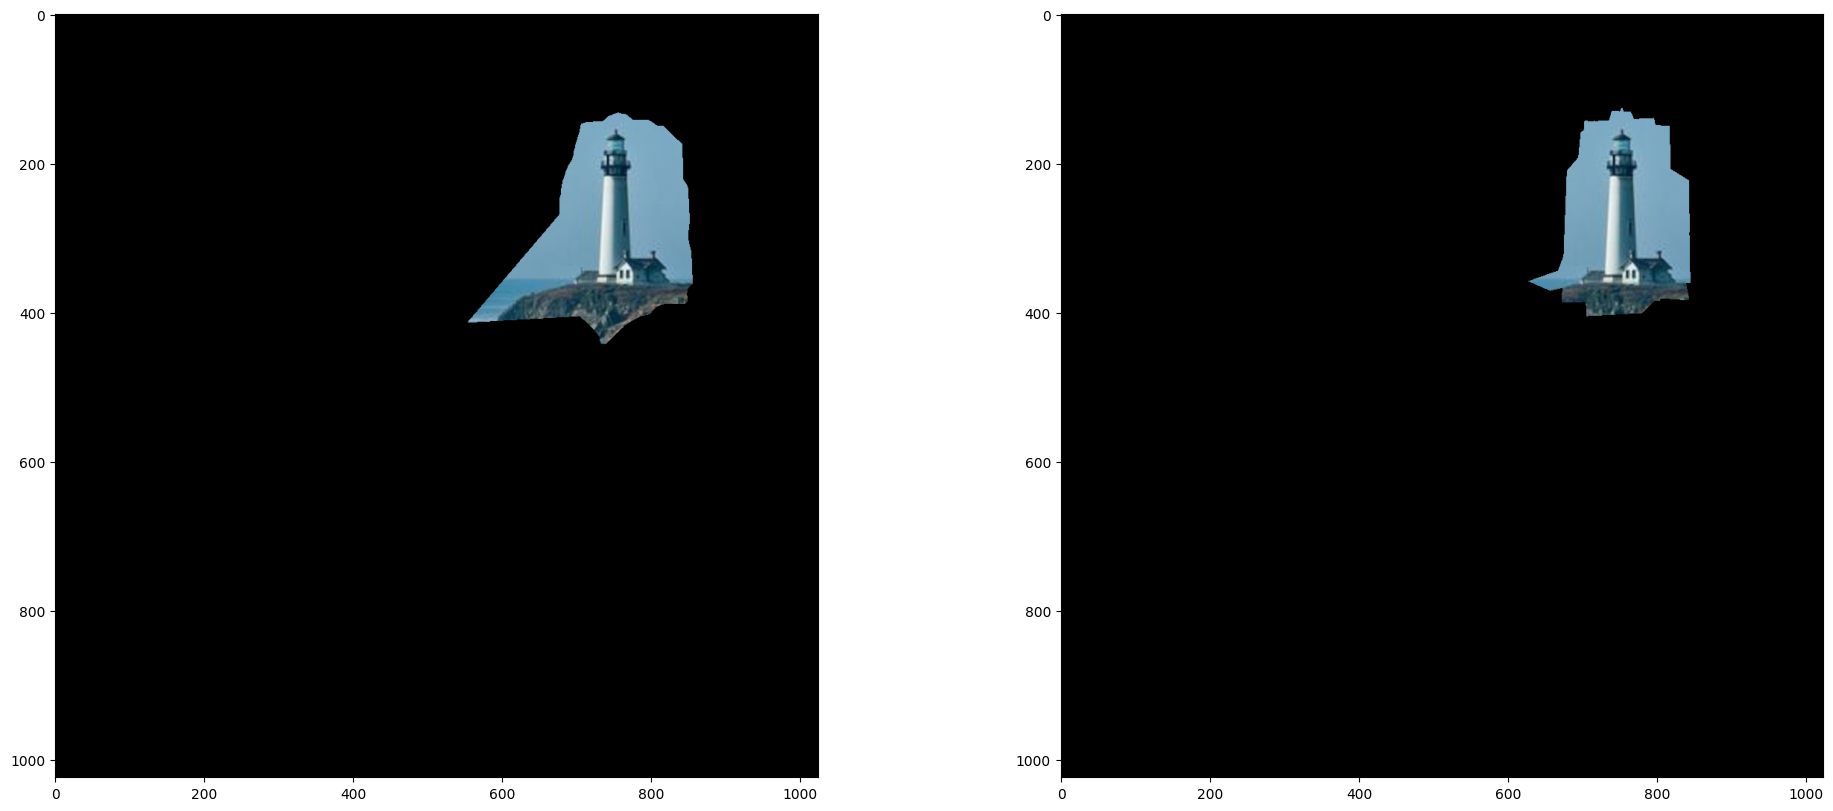

In [15]:
image_cutout_grad = get_percentage_of_image(orig_images[0],grad_mask,5)
fig, axes = plt.subplots(1,2,constrained_layout = True,figsize=(20,8))
axes[0].imshow(image_cutout_grad)
axes[1].imshow(image_cutout)

The image cutout now has a bit smoother edges and more importantly we can take a cutout of the desired size.

In [16]:
print("Size of cutout: " + str(np.mean(np.where(np.sum(image_cutout_grad,axis=2)!=0,1,0))))

Size of cutout: 0.049999237060546875
